# Análise de Churn de Clientes - Projeto de Data Science
**Autor**: 
Luis Felipe Barbosa Petrillo  
**LinkedIn**: https://www.linkedin.com/in/luisfelipebp/  
**GitHub**: https://github.com/luisfelipebp

## Objetivo
Analisar e prever o comportamento de churn (cancelamento) de clientes de uma empresa de telecomunicações utilizando técnicas de Machine Learning utilizando o dataset [Projeto Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) do Kaggle.

## Análise Gráfica dos dados
[Análise Gráfica](./Churn-Graphic.ipynb)


###  Configuração Inicial 

- Importação de pacotes essenciais

In [37]:
# Importação de Pacotes
from ydata_profiling import ProfileReport
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')

### Análise da Base de Dados de Churn de Clientes de Telecom

- Nesta seção, faremos a importação e análise inicial da base de dados de clientes. 

In [2]:
# Carregamento do conjunto de dados
df = pd.read_csv("./Telco-Customer-Churn.csv")

In [3]:
# Geração de relatório exploratório automático 
profile = ProfileReport(df, title="telco_churn_treino")
profile.to_file("telco_churn_treino.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 27.92it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Análise inicial dos dados
df.dtypes.value_counts()

object     18
int64       2
float64     1
Name: count, dtype: int64

In [5]:
# Identifica as colunas com maior quantidade de valores nulos
df.isnull().sum().sort_values(ascending=False).head(5)

customerID          0
DeviceProtection    0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
dtype: int64

In [6]:
# Exibe os 4 primeiros registros
df.head(4)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
# Verifica a quantidade de valores únicos em cada coluna (cardinalidade)
df.nunique().sort_values(ascending=False)


customerID          7043
TotalCharges        6531
MonthlyCharges      1585
tenure                73
PaymentMethod          4
DeviceProtection       3
Contract               3
StreamingMovies        3
StreamingTV            3
TechSupport            3
OnlineBackup           3
OnlineSecurity         3
InternetService        3
MultipleLines          3
gender                 2
PhoneService           2
PaperlessBilling       2
Dependents             2
Partner                2
SeniorCitizen          2
Churn                  2
dtype: int64

### Tratamento dos Dados

- Nesta etapa, vamos transformar variáveis categóricas em forma numérica para utilização em modelos de previsão.

In [9]:
# Converte colunas com duas categorias (Yes/No) para 1 e 0
binary_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_columns:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Opicionalmente, mapear gênero (Male/Female) da mesma forma
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

In [10]:
# Transformando as variáveis categóricas ordinais (onde a ordem dos valores tem importância)
# para valores numéricos utilizando o OrdinalEncoder

from sklearn.preprocessing import OrdinalEncoder

order = [['Month-to-month', 'One year', 'Two year']]  

encoder = OrdinalEncoder(categories=order)
df[['Contract']] = encoder.fit_transform(df[['Contract']])

In [11]:
#Transformando as variáveis categóricas nominais (sem ordem) em múltiplas colunas binárias utilizando o OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore',dtype='int32')

cols_ohe = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 
    'StreamingTV', 'StreamingMovies', 'PaymentMethod'
]

ohe = ohe.fit(df[cols_ohe])

# Configura o codificador para ignorar categorias desconhecidas e gerar resultados em inteiros
ohe.transform(df[cols_ohe]).toarray()

# Cria um novo DataFrame com as colunas One-Hot e nomes explícitos
ohe_df = pd.DataFrame(ohe.transform(df[cols_ohe]).toarray(),columns=ohe.get_feature_names_out())

In [12]:
# Substitui as colunas originais pelas colunas One-Hot no DataFrame final
df = pd.concat([df,ohe_df],axis=1)

In [13]:
# Remove as colunas com os valores antes da transformação
df = df.drop(cols_ohe,axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               7043 non-null   object 
 1   gender                                   7043 non-null   int64  
 2   SeniorCitizen                            7043 non-null   int64  
 3   Partner                                  7043 non-null   int64  
 4   Dependents                               7043 non-null   int64  
 5   tenure                                   7043 non-null   int64  
 6   PhoneService                             7043 non-null   int64  
 7   Contract                                 7043 non-null   float64
 8   PaperlessBilling                         7043 non-null   int64  
 9   MonthlyCharges                           7043 non-null   float64
 10  TotalCharges                             7043 no

In [14]:
df['TotalCharges'] = df["TotalCharges"].str.replace(',', '.', regex=True).str.replace('h', '.', regex=True).apply(pd.to_numeric, errors='coerce')

In [15]:
# Substitui os valores nulos pela média da coluna
df.loc[df['tenure'] == 0, 'TotalCharges'] = 0

###  Modelo de Treinamento de Classificação

- Nesta etapa, vamos treinar e comparar três algoritmos de classificação:
1. **Árvore de Decisão**  
2. **K-Nearest Neighbors (KNN)**  
3. **Regressão Logística** 

In [16]:
# Importando o train_test_split
from sklearn.model_selection import train_test_split

In [17]:
# Separando features (X) e target (y)
# Excluímos colunas não relevantes para o modelo (customerID e Churn)
X = df.drop(['customerID','Churn'],axis=1)
y = df.Churn

In [18]:
# Divisão em treino (67%) e teste (33%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

- Árvore de Decisão

In [19]:
from sklearn import tree

In [20]:
# Instancia o modelo de Árvore de Decisão
clf_ac = tree.DecisionTreeClassifier()
# Treina o modelo com os dados de treino
clf_ac = clf_ac.fit(X_train,y_train)
# Faz previsões no conjunto de teste
y_pred_ac = clf_ac.predict(X_test)

In [21]:
X_test = np.ascontiguousarray(X_test.values)  # Se X_test for um DataFrame

- K-Nearest Neighbors (KNN)

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
# Instancia o modelo KNN com 3 vizinhos
clf_knn = KNeighborsClassifier(n_neighbors=3)
# Treina o modelo com os dados de treino
clf_knn = clf_knn.fit(X_train,y_train)
# Faz previsões no conjunto de teste
y_pred_knn = clf_knn.predict(X_test)

- Regressão Logística

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
# Instancia o modelo com aumento de iterações para garantir convergência
clf_rl = LogisticRegression(max_iter=1000)
# Treina o modelo
clf_rl = clf_rl.fit(X_train,y_train)
# Faz previsões
y_pred_rl = clf_rl.predict(X_test)

- Verificando acurácia

In [26]:
# Importando
from sklearn.metrics import accuracy_score

In [27]:
acuracia_arvore = accuracy_score(y_test, y_pred_ac)
acuracia_knn = accuracy_score(y_test, y_pred_knn)
acuracia_rl = accuracy_score(y_test, y_pred_rl)

In [28]:
print(f"Acurácia Árvore: {acuracia_arvore:.2f}")
print(f"Acurácia KNN: {acuracia_knn:.2f}")
print(f"Acurácia Regressão Logística: {acuracia_rl:.2f}")

Acurácia Árvore: 0.73
Acurácia KNN: 0.75
Acurácia Regressão Logística: 0.81


In [29]:
# Importando
from sklearn.metrics import confusion_matrix

In [30]:
# árvore
confusion_matrix(y_test, y_pred_ac)

array([[1368,  326],
       [ 303,  328]], dtype=int64)

In [31]:
# knn
confusion_matrix(y_test, y_pred_knn)

array([[1442,  252],
       [ 338,  293]], dtype=int64)

In [32]:
# regressão logística
confusion_matrix(y_test, y_pred_rl)

array([[1528,  166],
       [ 287,  344]], dtype=int64)

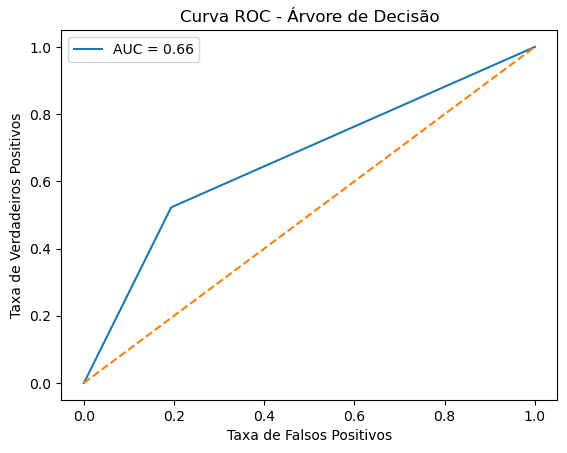

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score

# probabilidades de classe positiva
y_probs = clf_ac.predict_proba(X_test)[:, 1]  # clf_ac = modelo de árvore

# calcular FPR e TPR
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# calcular AUC
auc_score = roc_auc_score(y_test, y_probs)

plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Árvore de Decisão')
plt.legend()
plt.show()

